In [214]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf

from pathlib import Path

from skimage import color
from skimage.transform import resize
from skimage.filters import threshold_otsu
from skimage.filters import threshold_local
from skimage.filters import try_all_threshold


from matplotlib.patches import Rectangle
from matplotlib.pyplot import figure


from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image


from keras.models import Sequential
from keras.layers import Conv2D

#Seperate file containing custom functions
from my_functions import * 

# Counting the characters

Before we get started with trying to predict the characters, it would be useful to get an idea of how many characters we will be working with. The data set is arranged such that each individual book is a folder with two sub folders and a csv file.

The two sub folders are called 'images' and 'characters'. The 'images' folder contains the actual pages from the book. The 'characters' folder contains several sub directories which correspond to individual written characters (labelled as unicode). Within each sub directory are .jpg files of the individual characters themselves. The csv files contain coordinate information about where each character image is located in each page.

At the moment, we are not interested in the 'images' folders or csv files (we will come back to them). However, we can use the characters sub folders and .jpg files within them to get an initial idea of the data.

By counting the amount of .jpg files in each character sub folder, we can see how many instances of specific characters appear across the books.

In [2]:
#Collect the total amount of unique characters in the books and the amount of each individual character
directory = './all/'
classes = []
observations = []
#images = []
book_id = []
filepaths = []
count =[]

#Traverse through each sub directory in the 'characters' folder 
#skipping the whole pages and coodinate csv files

skip = ["str-images", "str-coordinate"]
for subdir, dirs, files in os.walk(directory):
    count = 0
    if dirs in skip:
            continue
    for filename in files:
        filepath = subdir + os.sep + filename
        #Counting the number of instances of individual characters
        if (filepath.endswith(".jpg")) & ("images" not in filepath):
            count += 1
            filepaths.append(filepath)
            classes.append(Path(subdir).stem)
            book_id.append(Path(subdir).parts[1])
    

In [3]:
#char = plt.imread(subdir+filename)
book_id
subdir
len(filepaths)
def checkIfDuplicates_1(listOfElems):
    ''' Check if given list contains any duplicates '''
    if len(listOfElems) == len(set(listOfElems)):
        return False
    else:
        return True




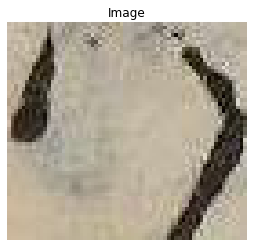

1086326

In [4]:
checkIfDuplicates_1(filepaths)
x = plt.imread(filepaths[344])
show_image(x)

len(filepaths)



# Preparing the DataFrame

Now, let's tidy up the data into a dataframe to make it more manageable for visualization purposes. In the previous step, we obtained two lists. One containing the seperate character classes, and one containing the count of each character in eeach book.

However, because we searched through each book one-by-one, we have repeating characters. In this step we will count the total number of instances of each character across all books and store it in an easily interpretable dataframe.

In [5]:
#Prepare a dataframe to view the total character counts
my_data = pd.DataFrame(columns = ["Book ID","Unicode","File","Count"])

#Add the data as columns to the data frame
classes = pd.Series(classes)
book_id = pd.Series(book_id)
image_files = pd.Series(filepaths)

observations = pd.Series(np.ones(len(filepaths)))


my_data['Unicode'] = classes
my_data['Book ID'] = book_id
my_data['File'] = image_files

my_data['Count'] = observations.astype(int)

my_data_literal = []

for i in range(0,my_data.shape[0]):
    unicode = classes[i]
    my_data_literal.append(chr(int(unicode[2:], 16)))
    
#Add the literal characters as a column to the data frame
my_data.insert(2, "Character", my_data_literal, True) 

#Preview the final data frame
my_data.head(20)



,Book ID,Unicode,Character,File,Count
0,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
1,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
2,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
3,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
4,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
5,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
6,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
7,200019865,U+7537,男,./all/200019865/characters/U+7537/U+7537_20001...,1
8,200019865,U+6075,恵,./all/200019865/characters/U+6075/U+6075_20001...,1
9,200019865,U+6075,恵,./all/200019865/characters/U+6075/U+6075_20001...,1


In [6]:
#View the total number of individual characters in the data set
my_data['Count'].sum()

1086326

In [240]:
#View the shape of the dataframe
my_data.shape

#Save the dataframe as a csv
my_data.to_csv('kuzushiji_raw.csv', index=False) 

---
At the moment the dataframe creates seperate rows for the same characters that appear across multiple books. So we should create a new dataframe where the number of character appearances are summed together across all books.

---

In [241]:
#Group the characters by their unicodes to get the total number of apperances for each character across all books
by_kanji = my_data.groupby(["Unicode"])["Count"].sum()

#Seperate the characters and counts into lists
unicodes = by_kanji.index.values.tolist()
total_observations = by_kanji.tolist()

#Create a new dataframe
total_df = pd.DataFrame()
total_df.insert(loc=0, column='Unicode', value=unicodes)

#Create a list to store the literal characters
character_literal = []

#Convert from unicode to literal characters
for i in range(0,len(unicodes)):
    uni = unicodes[i]
    character_literal.append(chr(int(uni[2:], 16)))
    
#Add the literal characters as a column to the data frame
total_df.insert(1, "Character", character_literal, True) 

#Add the counts of each character 
total_df.insert(2,"Count",total_observations)

#Preview the new dataframe
total_df.head(20)

#Save the new dataframe as a csv
total_df.to_csv('kuzushiji_grouped_by_character.csv', index=False) 

# Inspecting the data

First let's inspect the data we are working with to get an idea of its characteristics. 

In [9]:
#Shape of the dataframe
print("Shape of dataframe: "+str(total_df.shape))
total_char = total_df['Count'].sum()
print("Total characters: "+str(total_char))

Shape of dataframe: (4328, 3)
Total characters: 1086326


---
We can see that the dataframe has 4328 rows which means that there are 4328 unique characters which appear across the texts. We can also see that 1,086,326 characters appear across the texts in total. 

---

In [10]:
#Checking to find the most commonly occuring character
most_common = total_df[total_df["Count"] == total_df['Count'].max()]
print(most_common)

rate_of_freq = round(float(most_common['Count']/total_char),5)

print("\nThe most commonly occuring character accounts for: "+str(rate_of_freq*100)+"% of the total observations.")



   Unicode Character  Count
91  U+306E         の  41293

The most commonly occuring character accounts for: 3.801% of the total observations.


---
We can see that the most commonly occuring character の occurs 41,293 times in the data set, which accounts for about 3.8% of the total observations. In modern Japanese this charater is used for a range of different grammatical purposes including: 

Ownership: 
   "this is <b>my</b> computer."
   "He is Luke<b>'s</b> brother."

As an indefinate pronoun:
    "Would you prefer the red <b>one</b>, or the blue <b>one</b>?"

As a prepositional word, similar to the English word 'of':
"The bank <b>of</b> London"

---

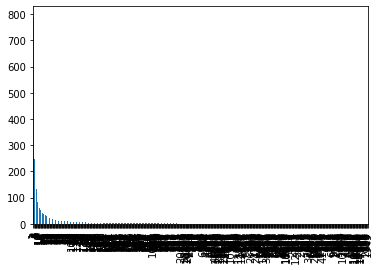

In [11]:
#Frequency plot of the full data set
total_df['Count'].value_counts().plot(kind ='bar')

---
Due to the large number of classes, the above plot is difficult to interpret, but it alludes to problem with this data set. We can see from this plot that while some classes have a large amount of observations, the majority of classes have very few observations. Let's explore this further.

---

In [12]:
#printing summary statistics
print(total_df.describe())


#Investigating the numbers of observations in the classes
total_less_than(1,total_df)

total_less_than(100,total_df)

total_greater_than(2000,total_df)
total_greater_than(30000,total_df)


              Count
count   4328.000000
mean     250.999538
std     1851.491931
min        1.000000
25%        2.000000
50%       10.000000
75%       53.000000
max    41293.000000

Number of characters with 1 or fewer observations: 790
This makes up: 18.25% of the classes

Number of characters with 100 or fewer observations: 3578
This makes up: 82.67% of the classes

Number of characters with 2000 or more observations: 77
This makes up: 1.78% of the classes

Number of characters with 30000 or more observations: 4
This makes up: 0.09% of the classes


In [13]:
#Investigating the top 10 characters with the highest amount of observations
top_10 = total_df.nlargest(10,['Count'])
print(top_10)

#The difference in obsevations between the most frequent and the 10th most frequent
(top_10['Count'].max())-(top_10['Count'].min())

    Unicode Character  Count
91   U+306E         の  41293
88   U+306B         に  40179
68   U+3057         し  37747
83   U+3066         て  32161
85   U+3068         と  28899
56   U+304B         か  26894
92   U+306F         は  26120
126  U+3092         を  25829
119  U+308A         り  24447
87   U+306A         な  24157


17136

Here, we have printed the top 10 most frequent characters in the data set. We can see that the different between the most frequent character, の and the 10th most frequent character, な is 17,136.

This demonstrates a tendency to see a rapid drop in character frequency. Below, is a plot showing the frequency of the top 10 most frequent characters visually.

<Figure size 1536x1024 with 0 Axes>

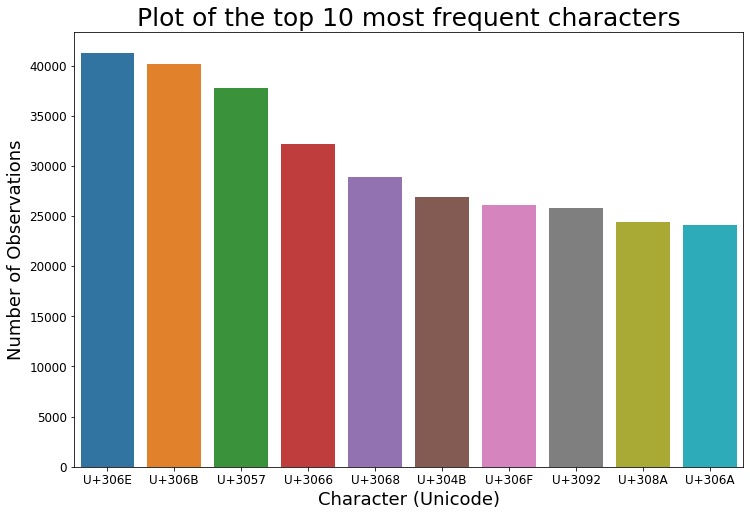

In [14]:
#Plot the top 10 most frequent characters by the amount of observations
figure(num=None, dpi=256, facecolor='w', edgecolor='r')
plt.figure(figsize=(12, 8))
top_10_plot = sns.barplot(x = top_10['Unicode'], y = top_10['Count'])

#Adjust the visual parameters of the plot
top_10_plot.axes.set_title("Plot of the top 10 most frequent characters",fontsize=25)
top_10_plot.set_xlabel("Character (Unicode)",fontsize=18)
top_10_plot.set_ylabel("Number of Observations",fontsize=18)
top_10_plot.tick_params(labelsize=12)
plt.savefig('top_10_plot.png')

plt.show()

We will now inspect the inter quartile range visually. The 75th percentile of character frequency was 53, and the 25th percentile was 2. So we will isolate and investigate the character classes which had between 2 and 53 observations.

In [15]:
#Visualizing the inter quartile range

#Isolate the classes with less than 53 and more than 2 observations
top_iqr = total_df['Count'] <= 53
bottom_iqr = total_df['Count'] >= 2
iqr = total_df[top_iqr & bottom_iqr]

#Sort the values
iqr = iqr.sort_values(['Count'],ascending=False)

#Preview the IQR
print(iqr.head(20))
print("\nIQR shape: "+str(iqr.shape))

total_equal_to(53,total_df)
total_equal_to(2,total_df)



     Unicode Character  Count
179   U+30D5         フ     53
4059  U+9945         饅     53
629   U+537F         卿     53
287   U+4E7E         乾     53
1036  U+5BA4         室     53
3807  U+9285         銅     53
1611  U+653F         政     53
3560  U+8CCA         賊     53
3253  U+86C7         蛇     53
1401  U+616E         慮     53
3937  U+96D1         雑     53
495   U+518A         冊     52
2302  U+732B         猫     52
3744  U+90E1         郡     52
3928  U+96C1         雁     52
3568  U+8CE2         賢     52
3969  U+9759         静     52
2554  U+796D         祭     52
3678  U+8FF0         述     52
853   U+5805         堅     52

IQR shape: (2459, 3)

Number of characters with 53 observations: 11
This makes up: 0.3% of the classes

Number of characters with 2 observations: 388
This makes up: 9.0% of the classes


---
We can see that the interquartile range consists of 2,459 different classes. Visualizing this as a frequency plot in a clearly understandable manner poses a challenge. 

To overcome this, we will group the classes by the number of observations they have, and plot the number of observations, by the number of classes with that number of observations.

For example, there are 11 classes that have 53 observations, and 388 classes that have 2 observations. We will plot this information for each number of observations between 2 and 53.

---

<Figure size 1536x1024 with 0 Axes>

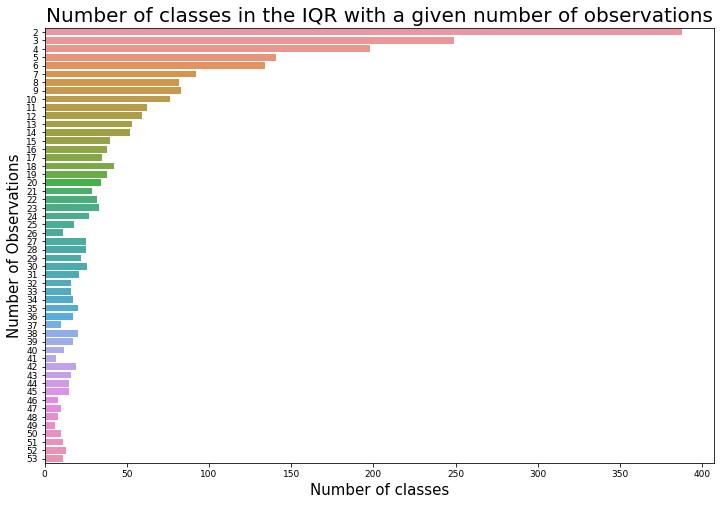

In [16]:
#Group the classes by the amount of observations, showing us how many classes had x observations.
iqr_class_counts = iqr['Count'].value_counts()
iqr_counts = iqr_class_counts.index.values.tolist()
iqr_num_of_classes = iqr_class_counts.tolist()

#Create a plot to visualize the amount of observations each class has within the inter quartile range.

figure(num=None, dpi=256, facecolor='w', edgecolor='r')
plt.figure(figsize=(12, 8))
iqr_plot = sns.barplot(x = iqr_num_of_classes, y = iqr_counts, orient='h')

#Adjust the visual parameters of the plot
iqr_plot.axes.set_title("Number of classes in the IQR with a given number of observations",fontsize=20)
iqr_plot.set_xlabel("Number of classes",fontsize=15)
iqr_plot.set_ylabel("Number of Observations",fontsize=15)
iqr_plot.tick_params(labelsize=9)
plt.savefig('IQR_classes_and_observations.png')

plt.show()

---
This reveals the unbalanced nature of the data. We can see that there are 388 classes with only 2 observations, approximately 250 classes with 3 observations, and appoximately 200 classes with only 4 observations.

This trend continues up until around 15 observations, where the amount of classes, with 15 observations or more, drops and remains below 50.

When we investigate this further we can see that a substantial amount of classes in the interquartile range have less than 15 observations.



In [17]:
#Investigate how many classes in the IQR have 15 observations or more, and how many have less than 15 observations
iqr_freq = iqr.groupby('Count')['Unicode'].size()
iqr_class_counts = iqr['Count'].value_counts()

above_or_equal_to_15 = sum(iqr_class_counts.values[iqr_class_counts.index.values>=15])
below_15 = sum(iqr_class_counts.values[iqr_class_counts.index.values<15])

print("Number of classes with 15 observations or more: "+str(above_or_equal_to_15))
print("Number of classes with less than 15 observations: "+str(below_15))



Number of classes with 15 observations or more: 790
Number of classes with less than 15 observations: 1669


## Conclusion from examining the data

Examining the summary statistics and plots above, we can see that the data is highly unbalanced. While the most frequently occuring character (の) has 41,293 observations, out of the 4,328 classes, 790 of them have only 1 observation (making up 18.25% of the total classes). 

Additionally 75% of the classes have less than 53 observations. By examining the interquartile range closely, we can also see that 790 have less than 15 observations. When we consider this in combination with the 790 classes with only 1 observation, 1,580 out of the 4,328 classes (or approximately 36.51%) have less than 15 observations.

Only 1.78% of the classes have 2000 or more observations, with 0.69% of the classes having 10,000 or more observations.

This poses an interesting challenge for the problem. Firstly, we will need to consider the metric which we use for evaluating our models. If we choose 'Accuracy', we will likely end up with a case where the model ignores the classes with few observations in favor of the minority of classes with many observations.

We will also need to consider a method for balancing the data. With the data as it is, there is a high chance of the models overfitting to the data, as it is likely that for many of the classes with few observations, we will end up with cases where 100% of the observations will be assigned to the training data set.

---


# Balancing the data

We will now try implementing a balancing algorithm to try to address the balancing issue. Firstly though, we will need to split the data into training and testing groups before applying the algorithm

In [227]:
labels = my_data['Unicode']

#Convert the unicode labels to numerical values
labels = labels.values.tolist()
label_encoder = LabelEncoder()
Y = np.array(label_encoder.fit_transform(labels))

#Create a training and testing set
x_train, x_test, y_train, y_test = train_test_split(my_data['File'], Y,random_state=42,train_size=0.001)

#Split the training set to create a validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) 


#Convert the pandas series to lists
x_train = x_train.tolist()
y_train = y_train.tolist()
x_val = x_val.tolist()
y_val = y_val.tolist()

print("The training set has "+ str(len(x_train))+" observations")
print("The validation set has "+ str(len(x_val))+" observations")
print("The test set has "+ str(len(x_test))+" observations")



The training set has 8147 observations
The validation set has 2716 observations
The test set has 1075463 observations


In [228]:
img_size = 224

#Load all of the images, convert them to grayscale and resize them all to 224 by 224.
x_train = process_images(x_train,img_size)
x_val = process_images(x_val,img_size)

In [2]:

sm = SMOTE(random_state=42)
#x_smote, y_smote = sm.fit_resample([x_train], y_train)
#x_train_




NameError: name 'SMOTE' is not defined

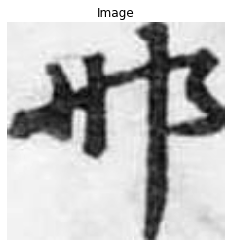

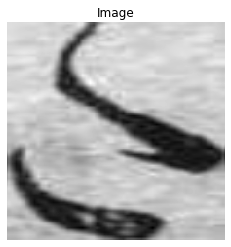

76

In [231]:

show_image(x_train[31])
show_image(x_val[30])
y_train[31]
y_val[30]



In [232]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[224,224]))
model.add(keras.layers.Dense(300,activation="relu"))
model.add(keras.layers.Dense(100,activation="relu"))
model.add(keras.layers.Dense(4328,activation="softmax"))


model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [233]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_val, y_val = np.array(x_val), np.array(y_val)


model.fit(x_train,y_train,epochs=30, validation_data=(x_val,y_val))

Epoch 1/30
255/255 [==============================] - 28s 109ms/step - loss: 5.8924 - accuracy: 0.0638 - val_loss: 5.3587 - val_accuracy: 0.0843
Epoch 2/30
255/255 [==============================] - 27s 107ms/step - loss: 4.9283 - accuracy: 0.1291 - val_loss: 4.8963 - val_accuracy: 0.1469
Epoch 3/30
255/255 [==============================] - 26s 103ms/step - loss: 4.5799 - accuracy: 0.1603 - val_loss: 4.9398 - val_accuracy: 0.1554
Epoch 4/30
255/255 [==============================] - 25s 98ms/step - loss: 4.3363 - accuracy: 0.1786 - val_loss: 4.6207 - val_accuracy: 0.2095
Epoch 5/30
255/255 [==============================] - 24s 95ms/step - loss: 4.1579 - accuracy: 0.1987 - val_loss: 4.6311 - val_accuracy: 0.2066
Epoch 6/30
255/255 [==============================] - 34s 134ms/step - loss: 3.9989 - accuracy: 0.2160 - val_loss: 4.5443 - val_accuracy: 0.2242
Epoch 7/30
255/255 [==============================] - 24s 95ms/step - loss: 3.8706 - accuracy: 0.2271 - val_loss: 4.5963 - val_accur

# Working with the images

Now let's start with examining the actual images that are contained within the data set. We will start with loading a sample image and viewing it with the show_image( ) function that we defined earlier.

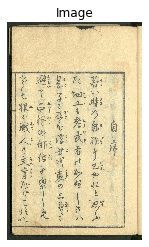

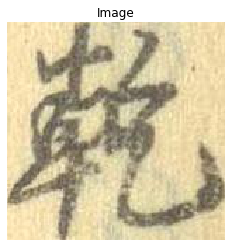

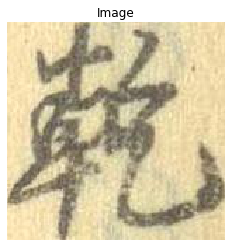

In [42]:
#Load a sample image and store the file's stem
file = Path("all/100241706/images/100241706_00004_2.jpg")
stem = Path("all/100241706/images/100241706_00004_2.jpg").stem

img = plt.imread(file)
show_image(img)



Now let's view a sample character image as well. In order to use the image with our classifier we will convert it to grayscale to make it easier to manage.

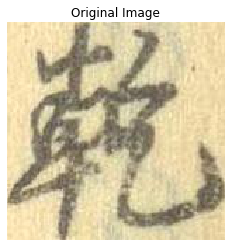

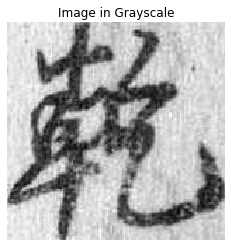

array([[[245, 223, 174],
        [244, 222, 173],
        [250, 228, 179],
        ...,
        [246, 224, 175],
        [241, 219, 170],
        [234, 212, 163]],

       [[243, 221, 172],
        [243, 221, 172],
        [249, 227, 178],
        ...,
        [244, 222, 173],
        [240, 218, 169],
        [235, 213, 164]],

       [[240, 218, 169],
        [242, 220, 171],
        [249, 227, 178],
        ...,
        [239, 217, 168],
        [239, 217, 168],
        [237, 215, 166]],

       ...,

       [[252, 230, 181],
        [242, 220, 171],
        [237, 215, 166],
        ...,
        [233, 211, 162],
        [236, 214, 165],
        [242, 220, 171]],

       [[254, 232, 183],
        [247, 225, 176],
        [243, 221, 172],
        ...,
        [228, 206, 157],
        [231, 209, 160],
        [235, 213, 164]],

       [[255, 233, 184],
        [251, 229, 180],
        [251, 229, 180],
        ...,
        [227, 205, 156],
        [228, 206, 157],
        [230, 208, 159]]

In [33]:
#Preview an individual character file
char = plt.imread("all/100241706/characters/U+4E7E/U+4E7E_100241706_00029_1_X1774_Y1384.jpg")
show_image(char,"Original Image")

#In order to use this file with a classifier, we will convert it to grayscale
img2_gray = color.rgb2gray(char)
show_image(img2_gray,'Image in Grayscale')



In [1]:
datagen = ImageDataGenerator(
 rotation_range=40,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.2,
 zoom_range=0.2,
 horizontal_flip=False)

datagen.fit(char)

NameError: name 'ImageDataGenerator' is not defined

We gan see in the image that there is some very light marks from a character on the opposite side of the paper. In order to reduce these marks and make the character more visible, we will use a technique called 'thresholding' which involves transforming the grayscale image into a binary (black and white) image. Where the section of interest is white and the background is black.

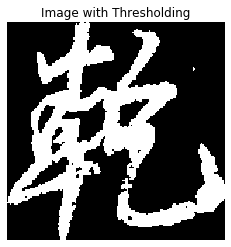

In [19]:
#We will apply thresholding to the grayscale image in order to make the contrast greater which will help the 
#classifier distinguish the chracter more easily

thresh_otsu = threshold_otsu(img2_gray)
binary_1 = img2_gray <= thresh_otsu 
show_image(binary_1, "Image with Thresholding")


In [20]:
#We will now import the coordinate information for the book
#This gives us the coordinates of each kanji character in the entire book
coordinates = pd.read_csv("all/100241706/100241706_coordinate.csv")
coordinates.head(10)

,Unicode,Image,X,Y,Block ID,Char ID,Width,Height
0,U+81EA,100241706_00004_2,1852,1736,B0001,C0001,104,219
1,U+5E8F,100241706_00004_2,1816,2096,B0001,C0002,152,296
2,U+82E5,100241706_00004_2,1465,951,B0001,C0003,172,216
3,U+3044,100241706_00004_2,1495,1218,B0001,C0004,143,69
4,U+6642,100241706_00004_2,1465,1338,B0001,C0005,168,179
5,U+306E,100241706_00004_2,1497,1567,B0001,C0006,123,152
6,U+6C17,100241706_00004_2,1504,1754,B0001,C0007,145,200
7,U+5F37,100241706_00004_2,1479,2034,B0001,C0008,163,145
8,U+306B,100241706_00004_2,1521,2239,B0001,C0009,83,237
9,U+5DF1,100241706_00004_2,1513,2500,B0001,C0010,127,117


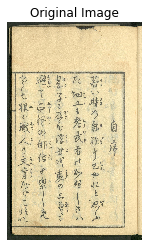

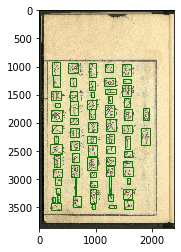

In [21]:
#An example of the find_characters function with the original page

show_image(img, "Original Image")

find_characters(img,stem,coordinates)


In [3]:
help(total_equal_toe)

Help on function show_image in module my_functions:

show_image(image, title='Image', cmap_type='gray')
    Takes an Image's file path as an input
    and displays the image.
    Can specify a title if desired

